# Experiment 07: Qualitative Comparison of All Models (20 Slices × 5 Models)

In this notebook, we perform a **qualitative side-by-side comparison** of all our trained models on the same set of slices.

**Goal**

We want to visually inspect how each incremental change in our pipeline affects ovary segmentation quality:

1. **Model 1 – Baseline U-Net**  
2. **Model 2 – Attention U-Net**  
3. **Model 3 – Attention U-Net + RAovSeg Preprocessing (20 epochs)**  
4. **Model 4 – Attention U-Net + RAovSeg Preprocessing (50 epochs)**  
5. **Model 5 – Attention U-Net + RAovSeg Preprocessing + Focal Tversky Loss**

For each of **20 validation (test-like) slices**, we will plot:

- The **input MRI slice** (what the model actually sees),
- The **ground truth ovary mask**, and
- The **predicted masks from all five models**, **without post-processing**.

This grid will serve as a **visual audit** of:
- False positives vs false negatives,
- Boundary quality,
- How each architectural / training change qualitatively changes the segmentation behaviour.

Formally, we are still using the **validation set**, but here we treat it as a **test-like holdout** purely for qualitative analysis.


In [4]:
# --- Imports and Setup ---

import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Find project root (folder that contains 'src')
# ------------------------------------------------------------------
project_root = os.path.abspath(".")
if not os.path.exists(os.path.join(project_root, "src")):
    # If we're inside notebooks/, go one level up
    project_root = os.path.abspath("..")

if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Detected project root: {project_root}")
print(f"Contents at root: {os.listdir(project_root)}")

from src.data_loader import UterusDataset, UterusDatasetWithPreprocessing
from src.models import UNet, AttentionUNet

# --- Configuration ---

manifest_path = os.path.join(project_root, "data", "d2_manifest_t2fs_ovary_eligible.csv")
image_size = 256

# Number of samples to visualize (rows in the grid)
num_samples_to_show = 20  # you can lower this if the grid is too tall

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load FULL datasets (no augmentation) ---

print("--- Loading full ovary datasets (plain + RAovSeg preprocessing) ---")
val_full_plain = UterusDataset(manifest_path=manifest_path, image_size=image_size, augment=False)
val_full_prep = UterusDatasetWithPreprocessing(manifest_path=manifest_path, image_size=image_size, augment=False)

# --- Reproduce the same train/validation split by patient ID (as in previous notebooks) ---

patient_ids = val_full_plain.manifest['patient_id'].unique()
split_idx = int(len(patient_ids) * 0.8)
train_ids, val_ids = patient_ids[:split_idx], patient_ids[split_idx:]

# Build list of slice indices that belong to validation patients
val_indices = [
    i
    for i, sm in enumerate(val_full_plain.slice_map)
    if val_full_plain.manifest.loc[sm['patient_index'], 'patient_id'] in val_ids
]

print(f"Total validation slices available: {len(val_indices)}")

# --- Select a fixed subset of validation slices for qualitative analysis ---

num_samples = min(num_samples_to_show, len(val_indices))
selected_indices = val_indices[:num_samples]  # deterministic: first N val slices

print(f"Using {num_samples} validation slices for the qualitative grid.")


Detected project root: c:\Users\lytten\programming\dlvr-project
Contents at root: ['.git', '.gitignore', '.vscode', 'archive', 'data', 'environment.yml', 'for-llm', 'material', 'models', 'notebooks', 'output', 'README.md', 'src', 'temp']
Using device: cuda
--- Loading full ovary datasets (plain + RAovSeg preprocessing) ---
Loading manifest from c:\Users\lytten\programming\dlvr-project\data\d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the uterus.
Loading manifest from c:\Users\lytten\programming\dlvr-project\data\d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Total validation slices available: 64
Using 20 validation slices for the qualitative grid.


In [5]:
# --- Load All Trained Models ---

models_dir = os.path.join(project_root, "models")

model_paths = {
    "Model 1: Baseline U-Net": os.path.join(models_dir, "07_ovary_baseline_best.pth"),
    "Model 2: Attention U-Net": os.path.join(models_dir, "09_attention_unet_best.pth"),
    "Model 3: Attn U-Net + Preproc (20e)": os.path.join(models_dir, "11_attention_unet_preprocessed_best.pth"),
    "Model 4: Attn U-Net + Preproc (50e)": os.path.join(models_dir, "13_attn_unet_prep_long_best.pth"),
    "Model 5: Attn U-Net + Preproc + Focal Tversky": os.path.join(models_dir, "15_attn_unet_focal_tversky_best.pth"),
}

loaded_models = {}

for name, path in model_paths.items():
    print(f"\nLoading {name} from: {path}")
    if "Baseline U-Net" in name:
        model = UNet(n_channels=1, n_classes=1).to(device)
    else:
        model = AttentionUNet(n_channels=1, n_classes=1).to(device)

    if not os.path.exists(path):
        raise FileNotFoundError(f"Expected model file not found: {path}")

    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    loaded_models[name] = model
    print(f"  -> Loaded {name} successfully.")

print("\nAll models loaded and set to eval() mode.")



Loading Model 1: Baseline U-Net from: c:\Users\lytten\programming\dlvr-project\models\07_ovary_baseline_best.pth
  -> Loaded Model 1: Baseline U-Net successfully.

Loading Model 2: Attention U-Net from: c:\Users\lytten\programming\dlvr-project\models\09_attention_unet_best.pth
  -> Loaded Model 2: Attention U-Net successfully.

Loading Model 3: Attn U-Net + Preproc (20e) from: c:\Users\lytten\programming\dlvr-project\models\11_attention_unet_preprocessed_best.pth
  -> Loaded Model 3: Attn U-Net + Preproc (20e) successfully.

Loading Model 4: Attn U-Net + Preproc (50e) from: c:\Users\lytten\programming\dlvr-project\models\13_attn_unet_prep_long_best.pth
  -> Loaded Model 4: Attn U-Net + Preproc (50e) successfully.

Loading Model 5: Attn U-Net + Preproc + Focal Tversky from: c:\Users\lytten\programming\dlvr-project\models\15_attn_unet_focal_tversky_best.pth
  -> Loaded Model 5: Attn U-Net + Preproc + Focal Tversky successfully.

All models loaded and set to eval() mode.



Generating qualitative grid...


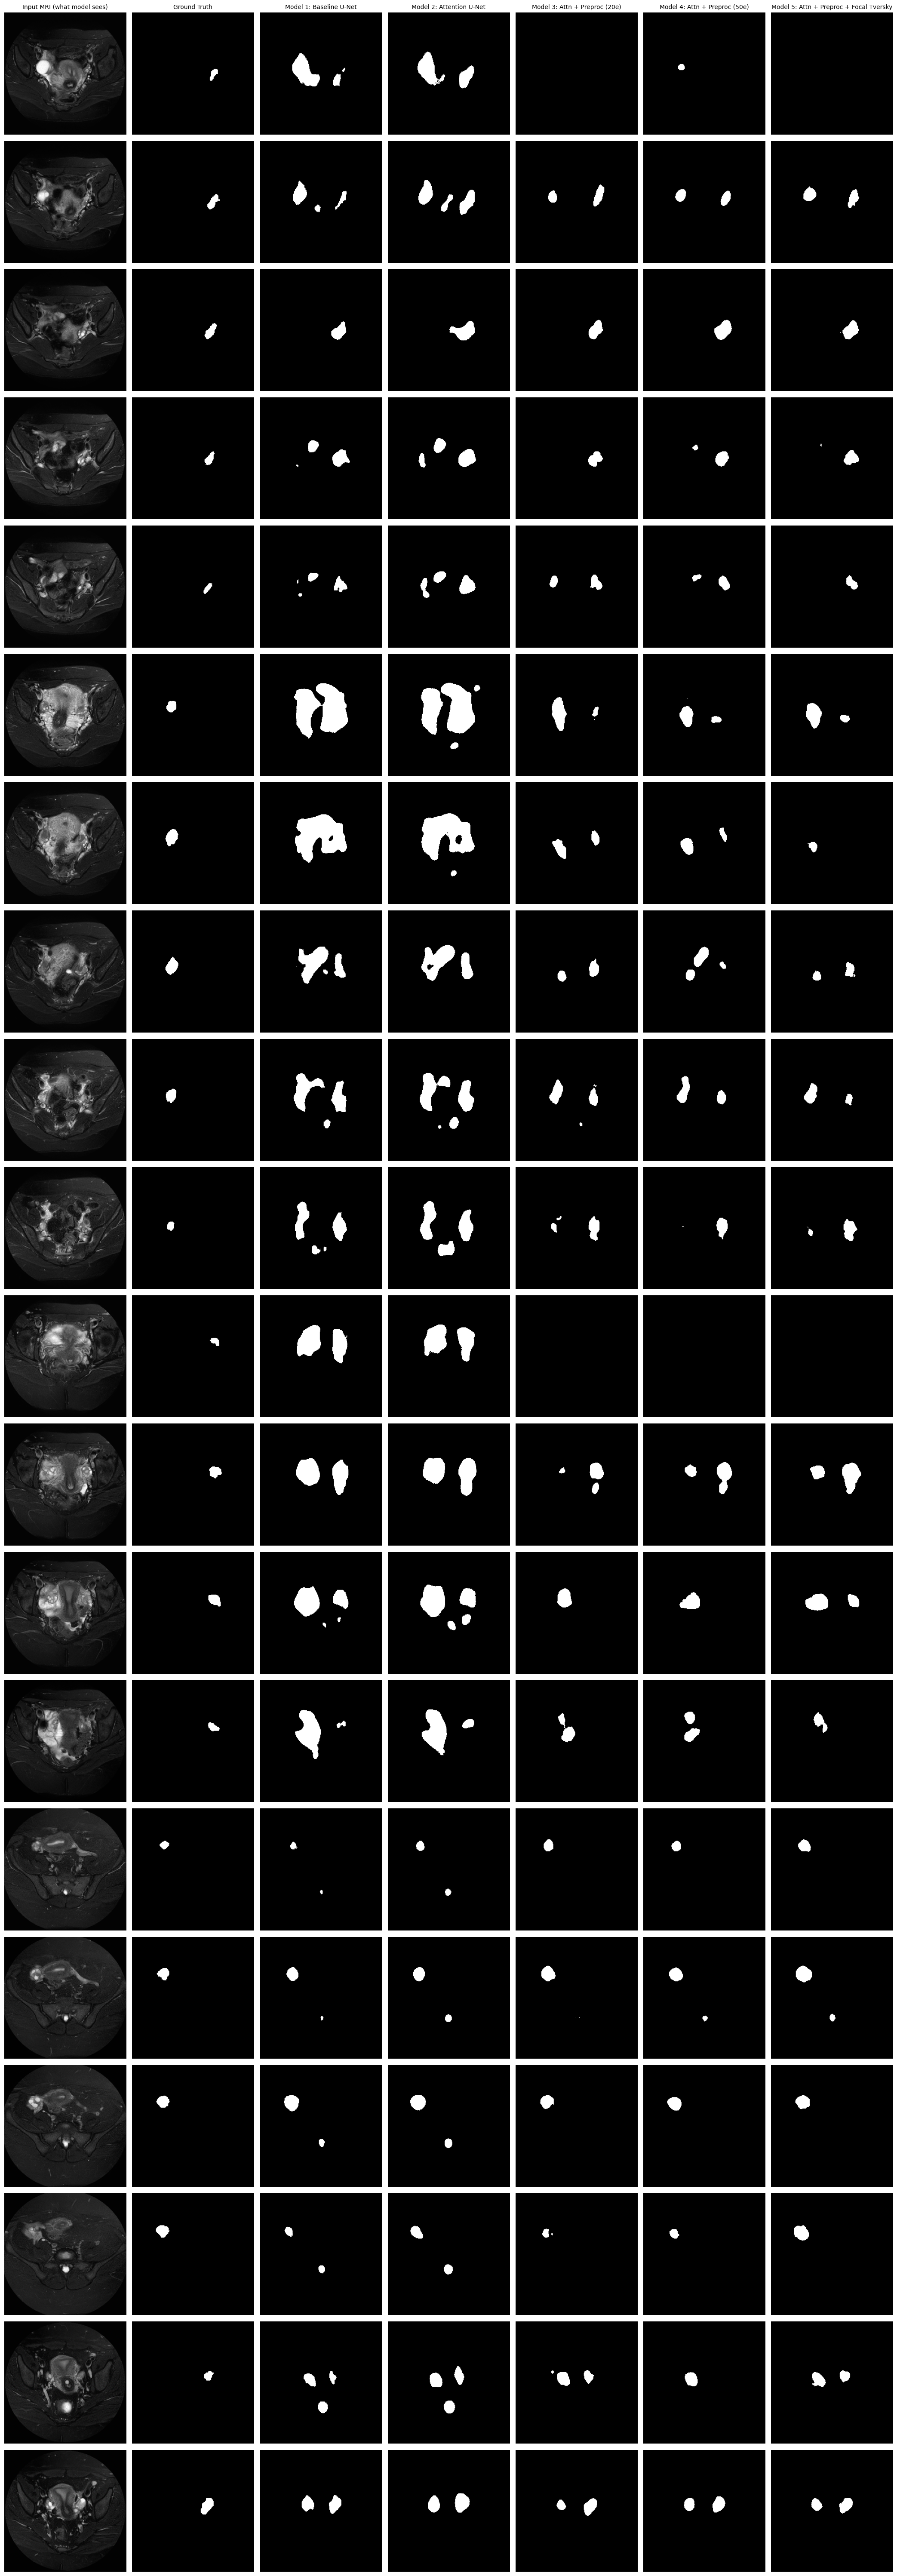

Done. Use this grid to describe qualitative differences between models in the report.


In [6]:
# --- Helper: Run Inference for a Single Image Tensor ---

def predict_mask(model, image_tensor, device):
    """
    image_tensor: shape (1, H, W), already preprocessed as the model expects.
    Returns: numpy array mask of shape (H, W) with values {0,1}.
    """
    model.eval()
    with torch.no_grad():
        # Add batch dimension: (1, 1, H, W)
        image_batch = image_tensor.unsqueeze(0).to(device)
        logits = model(image_batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
    return preds.squeeze().cpu().numpy()


# --- Build the Qualitative Grid ---

num_cols = 7  # Input, GT, + 5 models
fig, axes = plt.subplots(num_samples, num_cols, figsize=(3 * num_cols, 3 * num_samples))

if num_samples == 1:
    # Edge case: matplotlib collapses dims if only 1 row
    axes = np.expand_dims(axes, axis=0)

col_titles = [
    "Input MRI (what model sees)",
    "Ground Truth",
    "Model 1: Baseline U-Net",
    "Model 2: Attention U-Net",
    "Model 3: Attn + Preproc (20e)",
    "Model 4: Attn + Preproc (50e)",
    "Model 5: Attn + Preproc + Focal Tversky",
]

for col_idx, title in enumerate(col_titles):
    axes[0, col_idx].set_title(title, fontsize=10)

print("\nGenerating qualitative grid...")

for row_idx, dataset_idx in enumerate(selected_indices):
    # --- Load the SAME slice from both dataset variants ---
    # Plain version (used by models trained without RAovSeg preprocessing)
    image_plain, mask_tensor = val_full_plain[dataset_idx]
    # Preprocessed version (used by models trained with RAovSeg preprocessing)
    image_prep, _ = val_full_prep[dataset_idx]

    # Convert to numpy for visualization
    input_np = image_plain.squeeze().numpy()
    mask_np = mask_tensor.squeeze().numpy()

    # --- Run predictions for each model ---
    # 1) Baseline U-Net and 2) Attention U-Net take the plain-normalized MRI
    pred_baseline = predict_mask(loaded_models["Model 1: Baseline U-Net"], image_plain, device)
    pred_attn = predict_mask(loaded_models["Model 2: Attention U-Net"], image_plain, device)

    # 3–5) Preprocessed models take the RAovSeg-preprocessed MRI
    pred_attn_prep_20 = predict_mask(loaded_models["Model 3: Attn U-Net + Preproc (20e)"], image_prep, device)
    pred_attn_prep_50 = predict_mask(loaded_models["Model 4: Attn U-Net + Preproc (50e)"], image_prep, device)
    pred_attn_prep_ft = predict_mask(loaded_models["Model 5: Attn U-Net + Preproc + Focal Tversky"], image_prep, device)

    # --- Plot row: Input, GT, then each model prediction ---
    row_axes = axes[row_idx]

    # Column 0: Input MRI (plain normalized)
    row_axes[0].imshow(input_np, cmap='gray')
    row_axes[0].axis('off')

    # Column 1: Ground truth mask
    row_axes[1].imshow(mask_np, cmap='gray')
    row_axes[1].axis('off')

    # Column 2: Baseline U-Net
    row_axes[2].imshow(pred_baseline, cmap='gray')
    row_axes[2].axis('off')

    # Column 3: Attention U-Net
    row_axes[3].imshow(pred_attn, cmap='gray')
    row_axes[3].axis('off')

    # Column 4: Attn + Preproc (20 epochs)
    row_axes[4].imshow(pred_attn_prep_20, cmap='gray')
    row_axes[4].axis('off')

    # Column 5: Attn + Preproc (50 epochs)
    row_axes[5].imshow(pred_attn_prep_50, cmap='gray')
    row_axes[5].axis('off')

    # Column 6: Attn + Preproc + Focal Tversky
    row_axes[6].imshow(pred_attn_prep_ft, cmap='gray')
    row_axes[6].axis('off')

plt.tight_layout()
plt.show()

print("Done. Use this grid to describe qualitative differences between models in the report.")


Okay here is the result. A few things I note myself: Adding attention on its own doesn't do anything good, it kinda just makes the blobs bigger. Preprocessing is a massive difference. The model is definitely able to do way more precise segmentation when we add preprocessing. Important. Extra epochs doesn't do much, the differences seem like random noise. Focal tversky also doesn't seem to do much, differences look like random noise (sometimes better sometimes worse). Some extra, meta things, I'm noticing are: Some input slices the model has a way easier time segmenting. Some ground truths are found basically by every model. The big differences between the models come at the ones that are hard. Something the "easy" slices have in common are that there is this bright colored small cluster. Some ground truths are on the left and some are on the right. Never are there ground truths with 2 objects (2 ovaries) which is weird. However, our model seems to often want to segment 2 objects (2 ovaries), which makes me believe that the slices contain 2 ovaries but only one is segmented per slice. This could be a major issue if we are training the model to always find one ovary even though there are two. Seems there are very limited places the ovaries can be found on the pictures, based on the ground truth. So the model might just remember that. Data augmentation?

## Hardest vs Easiest Slices for Model 5 (Focal Tversky Loss)

The previous grid used 20 *arbitrary* validation slices. To better understand where our final model (Model 5: Attention U-Net + preprocessing + Focal Tversky) succeeds and fails, we now:

1. Compute the **Focal Tversky loss** for Model 5 on every validation slice.
2. Rank all slices by this loss.
3. Visualize:
   - The **10 easiest slices** (lowest loss), and  
   - The **10 hardest slices** (highest loss),

in a single grid.

This lets us:
- See what “easy” ovaries look like (shape, contrast, position) and how all models behave there.
- See what “hard” ovaries look like and how failure modes change across models.


In [7]:
# --- Compute Focal Tversky loss for Model 5 on all validation slices ---

from src.losses import FocalTverskyLoss

model5 = loaded_models["Model 5: Attn U-Net + Preproc + Focal Tversky"]
criterion_ft = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=4/3)

slice_losses = []

print("Computing Focal Tversky loss for Model 5 on all validation slices...")

model5.eval()
with torch.no_grad():
    for idx in val_indices:
        img_prep, mask = val_full_prep[idx]   # Model 5 expects preprocessed input

        # Add batch dimension: (1, 1, H, W)
        img_batch = img_prep.unsqueeze(0).to(device)
        mask_batch = mask.unsqueeze(0).to(device)

        logits = model5(img_batch)
        loss = criterion_ft(logits, mask_batch)

        slice_losses.append((idx, float(loss.item())))

# Sort by loss: ascending (easiest first)
slice_losses_sorted = sorted(slice_losses, key=lambda x: x[1])

print(f"Computed losses for {len(slice_losses_sorted)} validation slices.")

# Select top-10 easiest and top-10 hardest
k = 10
num_available = len(slice_losses_sorted)
k = min(k, num_available // 2)  # ensure we have at least 2k slices

easiest = slice_losses_sorted[:k]
hardest = slice_losses_sorted[-k:]

print(f"Using {k} easiest and {k} hardest slices.")
print("Easiest example losses:", [round(l, 4) for _, l in easiest])
print("Hardest example losses:", [round(l, 4) for _, l in hardest])

# Combine indices: easiest first, then hardest
ranked_indices = [idx for idx, _ in easiest] + [idx for idx, _ in hardest]


Computing Focal Tversky loss for Model 5 on all validation slices...
Computed losses for 64 validation slices.
Using 10 easiest and 10 hardest slices.
Easiest example losses: [0.0305, 0.0778, 0.0802, 0.0807, 0.0901, 0.0917, 0.0976, 0.101, 0.1162, 0.1735]
Hardest example losses: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Generating easiest+hardest qualitative grid...


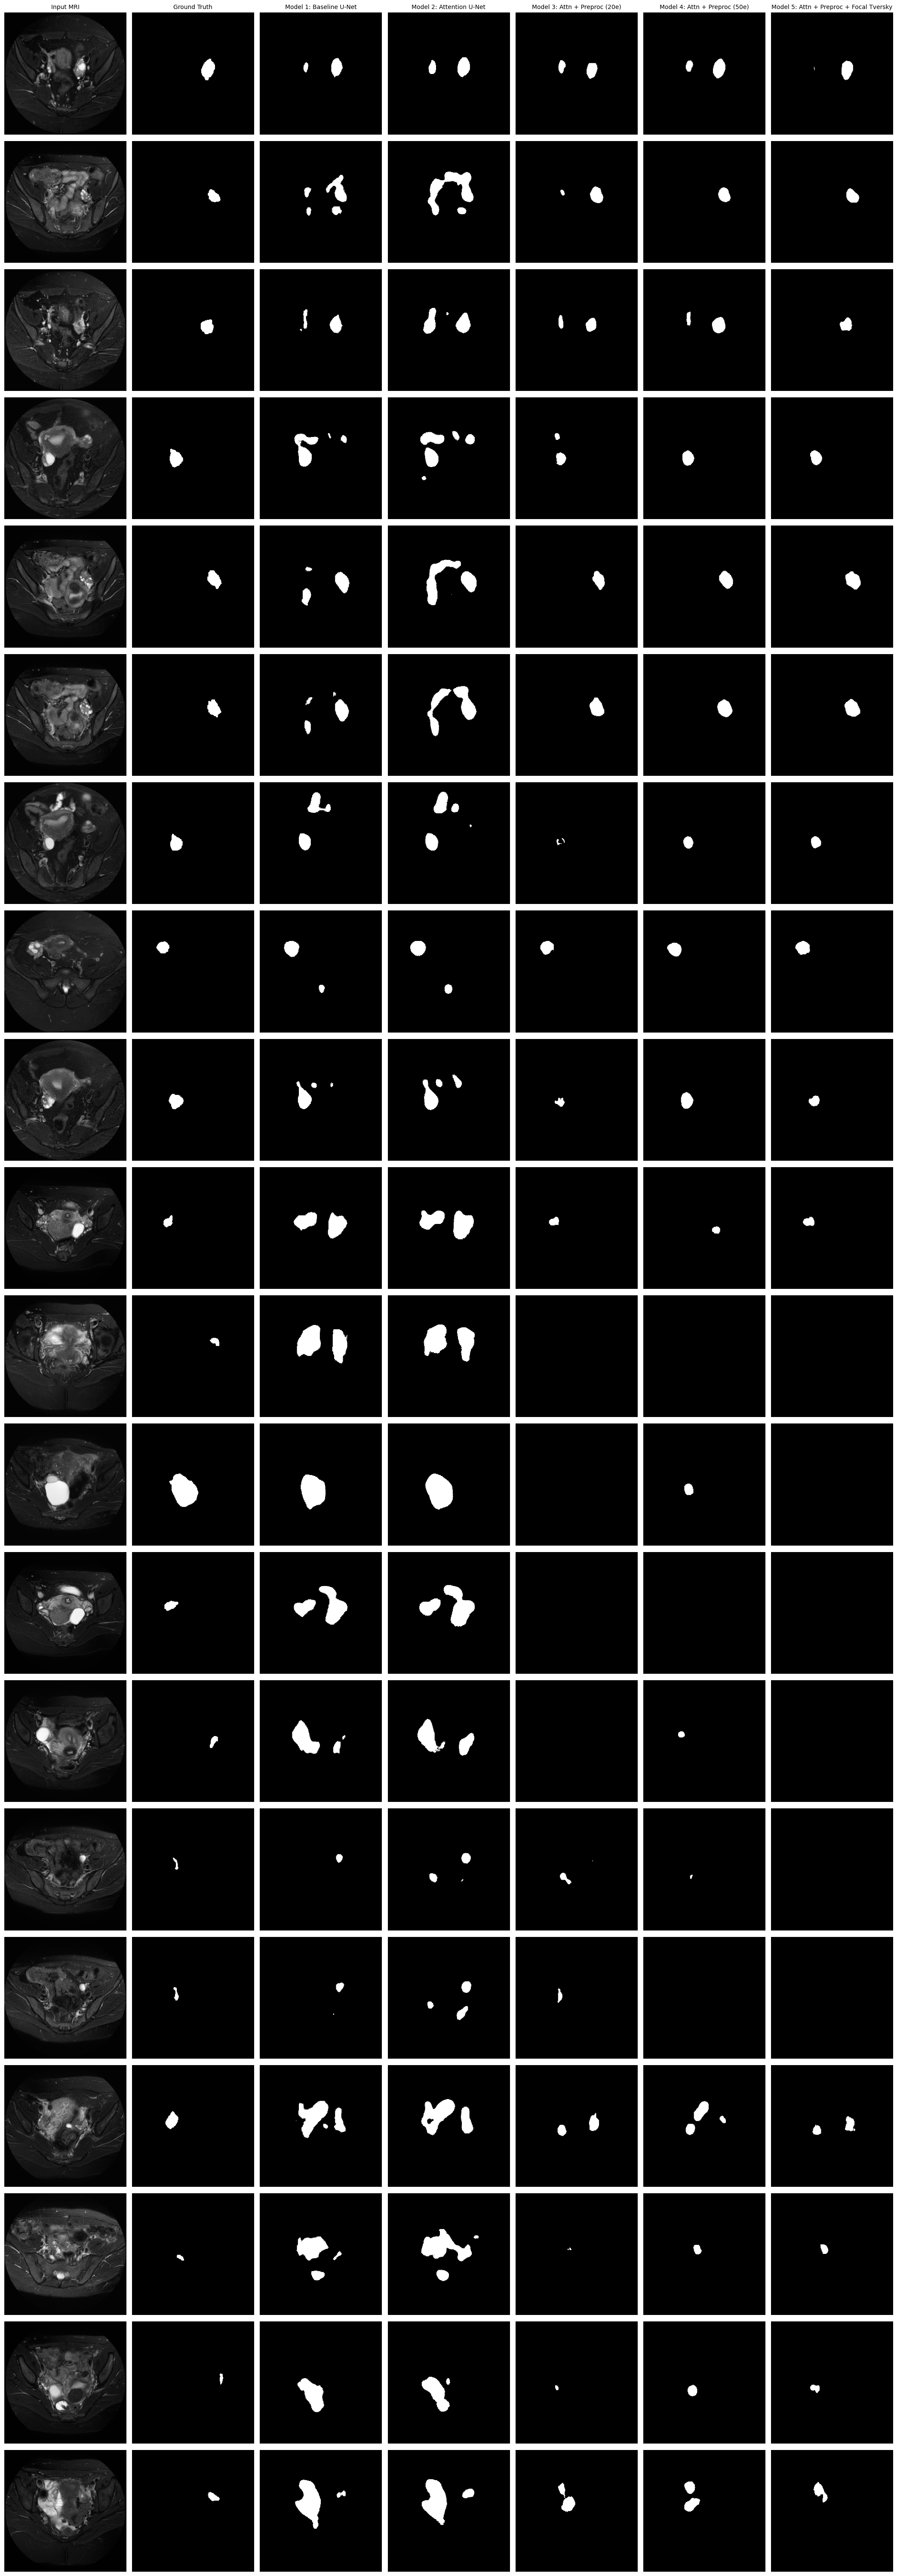

In [8]:
# --- Qualitative grid: easiest 10 + hardest 10 (by Model 5 loss) ---

def predict_mask_np(model, image_tensor, device):
    """Helper: returns binary mask (H, W) as numpy array."""
    model.eval()
    with torch.no_grad():
        img_batch = image_tensor.unsqueeze(0).to(device)
        logits = model(img_batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
    return preds.squeeze().cpu().numpy()

num_rows = len(ranked_indices)
num_cols = 7  # Input, GT, + 5 models

fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

col_titles = [
    "Input MRI",
    "Ground Truth",
    "Model 1: Baseline U-Net",
    "Model 2: Attention U-Net",
    "Model 3: Attn + Preproc (20e)",
    "Model 4: Attn + Preproc (50e)",
    "Model 5: Attn + Preproc + Focal Tversky",
]

for col_idx, title in enumerate(col_titles):
    axes[0, col_idx].set_title(title, fontsize=10)

print("Generating easiest+hardest qualitative grid...")

for row_idx, dataset_idx in enumerate(ranked_indices):
    # Plain + preprocessed versions of the SAME slice
    img_plain, mask_tensor = val_full_plain[dataset_idx]
    img_prep, _ = val_full_prep[dataset_idx]

    input_np = img_plain.squeeze().numpy()
    mask_np = mask_tensor.squeeze().numpy()

    # Predictions
    pred_m1 = predict_mask_np(loaded_models["Model 1: Baseline U-Net"], img_plain, device)
    pred_m2 = predict_mask_np(loaded_models["Model 2: Attention U-Net"], img_plain, device)
    pred_m3 = predict_mask_np(loaded_models["Model 3: Attn U-Net + Preproc (20e)"], img_prep, device)
    pred_m4 = predict_mask_np(loaded_models["Model 4: Attn U-Net + Preproc (50e)"], img_prep, device)
    pred_m5 = predict_mask_np(loaded_models["Model 5: Attn U-Net + Preproc + Focal Tversky"], img_prep, device)

    row_axes = axes[row_idx]

    # Column 0: Input MRI
    row_axes[0].imshow(input_np, cmap="gray")
    row_axes[0].axis("off")

    # Column 1: GT
    row_axes[1].imshow(mask_np, cmap="gray")
    row_axes[1].axis("off")

    # Column 2–6: predictions
    row_axes[2].imshow(pred_m1, cmap="gray"); row_axes[2].axis("off")
    row_axes[3].imshow(pred_m2, cmap="gray"); row_axes[3].axis("off")
    row_axes[4].imshow(pred_m3, cmap="gray"); row_axes[4].axis("off")
    row_axes[5].imshow(pred_m4, cmap="gray"); row_axes[5].axis("off")
    row_axes[6].imshow(pred_m5, cmap="gray"); row_axes[6].axis("off")

# Annotate which rows are "easy" vs "hard"
for i in range(len(ranked_indices)):
    label = "Easy" if i < k else "Hard"
    axes[i, 0].set_ylabel(label, rotation=90, fontsize=9, labelpad=10)

plt.tight_layout()
plt.show()


## Effect of Post-processing on Model 4 and Model 5 (Top 10 / Bottom 10 After Post-processing)

We now evaluate the impact of the RAovSeg post-processing step (binary closing + keeping the largest connected component) on our two best models:

- **Model 4** – Attention U-Net + preprocessing (50 epochs, DiceBCELoss)  
- **Model 5** – Attention U-Net + preprocessing + Focal Tversky Loss

Procedure:

1. For every validation slice, we run **Model 5**, threshold its prediction, apply the RAovSeg post-processing, and compute a Focal Tversky-style loss on the post-processed mask.
2. We rank all validation slices by this loss (lower = easier, higher = harder).
3. We visualize:
   - The **10 easiest** slices and the **10 hardest** slices after post-processing.
   - For each slice we show:
     - Input MRI
     - Ground truth
     - Model 4 (raw prediction)
     - Model 4 (after post-processing)
     - Model 5 (raw prediction)
     - Model 5 (after post-processing)

This lets us see when post-processing successfully removes extra blobs and when it actually harms performance by removing the correct ovary and keeping a larger false positive.


In [9]:
# --- Import RAovSeg post-processing and define a Focal Tversky-style loss on binary masks ---

from src.RAovSeg_tools import postprocess_  # binary closing + largest connected component

def focal_tversky_loss_binary(pred_bin, target, alpha=0.7, beta=0.3, gamma=4/3, smooth=1e-6):
    """
    Focal Tversky loss computed directly on binary (0/1) predictions.
    pred_bin, target: tensors of shape (1, 1, H, W) with values in {0, 1}.
    """
    p = pred_bin.view(-1)
    t = target.view(-1)

    TP = (p * t).sum()
    FP = ((1 - t) * p).sum()
    FN = (t * (1 - p)).sum()

    T = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    return (1 - T) ** gamma

# --- Compute per-slice loss for Model 5 AFTER post-processing ---

model4 = loaded_models["Model 4: Attn U-Net + Preproc (50e)"]
model5 = loaded_models["Model 5: Attn U-Net + Preproc + Focal Tversky"]

slice_losses_post = []

print("Computing Focal Tversky loss for Model 5 AFTER post-processing on all validation slices...")

model5.eval()
with torch.no_grad():
    for idx in val_indices:
        img_prep, mask = val_full_prep[idx]   # both models 4 and 5 expect preprocessed input

        img_batch = img_prep.unsqueeze(0).to(device)      # (1,1,H,W)
        mask_batch = mask.unsqueeze(0).to(device)

        logits = model5(img_batch)
        probs = torch.sigmoid(logits)
        pred_bin = (probs > 0.5).float()

        # Apply RAovSeg post-processing on the binary mask
        pred_np = pred_bin.squeeze().cpu().numpy().astype(np.uint8)
        post_np = postprocess_(pred_np)
        post_tensor = torch.from_numpy(post_np).unsqueeze(0).unsqueeze(0).float().to(device)

        loss_val = focal_tversky_loss_binary(post_tensor, mask_batch)
        slice_losses_post.append((idx, float(loss_val.item())))

# Sort by loss: easiest (lowest loss) to hardest (highest loss)
slice_losses_post_sorted = sorted(slice_losses_post, key=lambda x: x[1])

print(f"Computed post-processed losses for {len(slice_losses_post_sorted)} validation slices.")

k = 10
num_available = len(slice_losses_post_sorted)
k = min(k, num_available // 2)

easiest_post = slice_losses_post_sorted[:k]
hardest_post = slice_losses_post_sorted[-k:]

print(f"Using {k} easiest and {k} hardest slices AFTER post-processing.")
print("Post-processed easiest losses:", [round(l, 4) for _, l in easiest_post])
print("Post-processed hardest losses:", [round(l, 4) for _, l in hardest_post])

post_ranked_indices = [idx for idx, _ in easiest_post] + [idx for idx, _ in hardest_post]


Computing Focal Tversky loss for Model 5 AFTER post-processing on all validation slices...
Computed post-processed losses for 64 validation slices.
Using 10 easiest and 10 hardest slices AFTER post-processing.
Post-processed easiest losses: [0.0268, 0.0523, 0.0772, 0.0788, 0.0794, 0.0856, 0.0881, 0.0918, 0.0929, 0.0964]
Post-processed hardest losses: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Generating qualitative grid with post-processing...


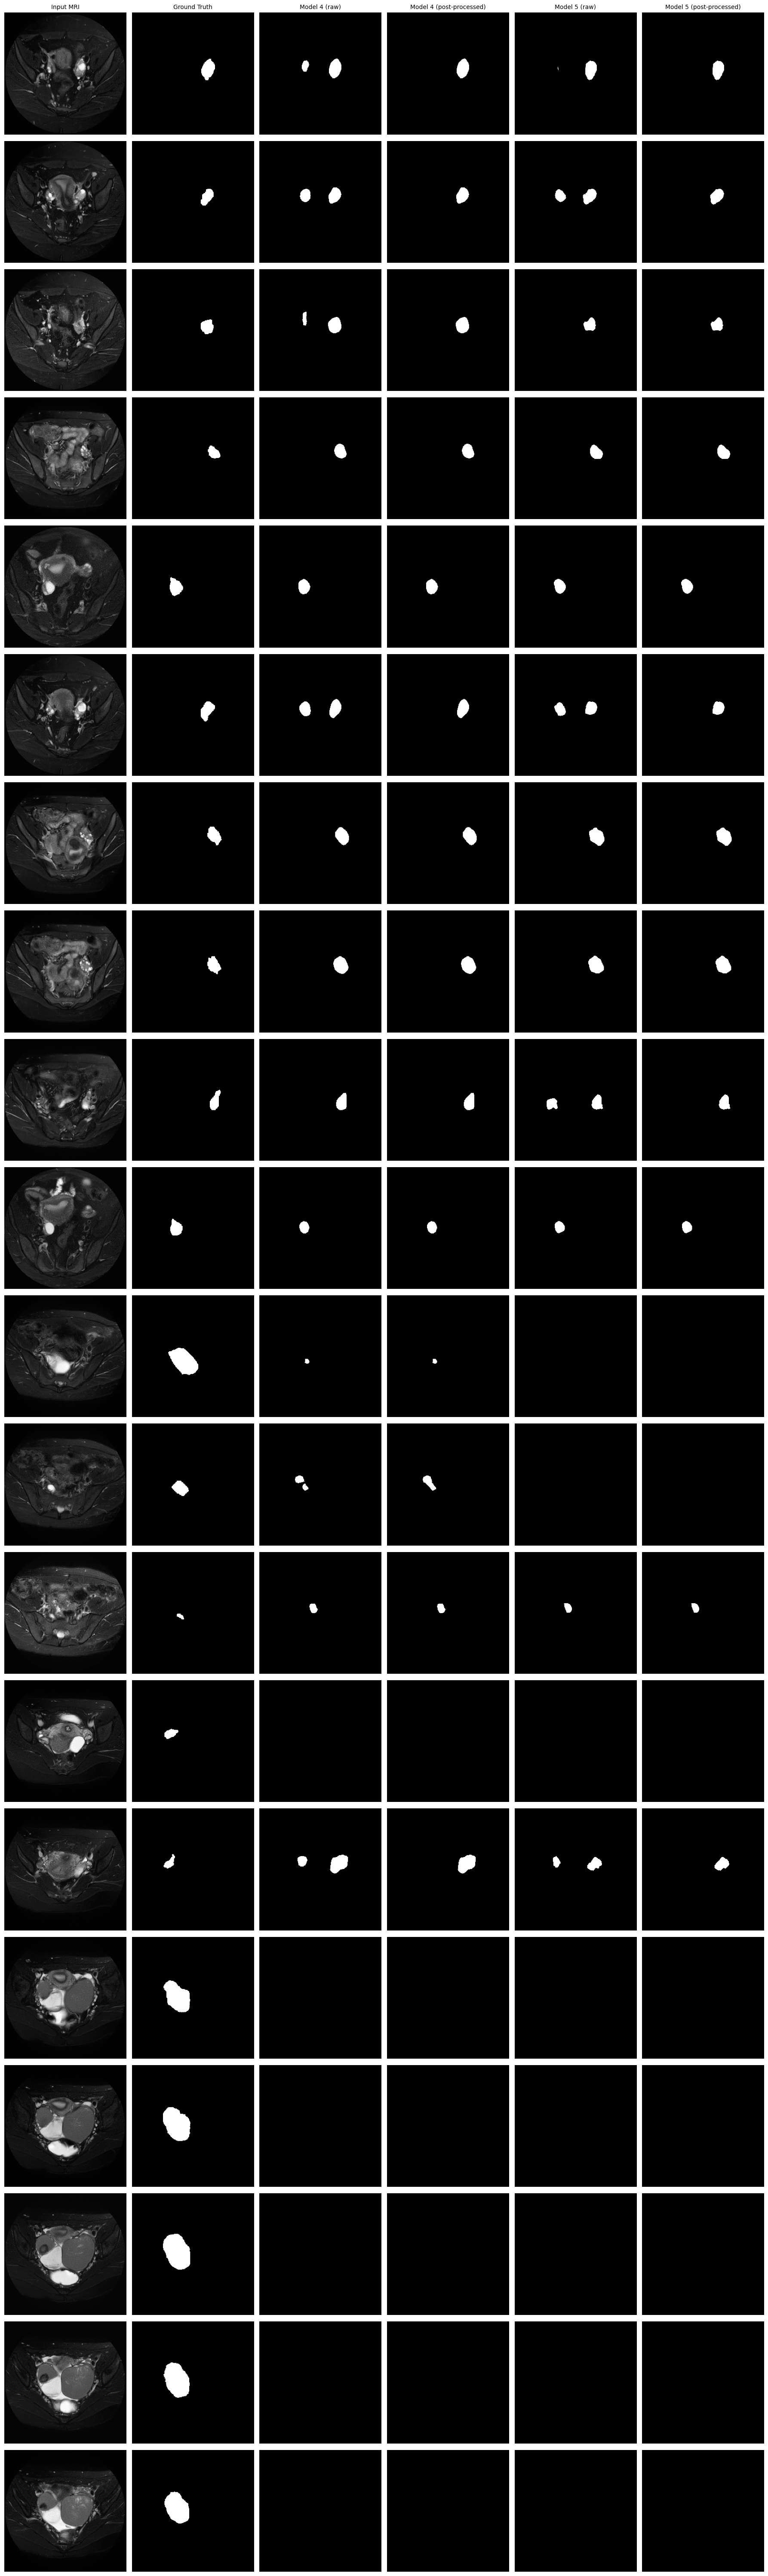

In [10]:
# --- Qualitative grid: Model 4 & 5 before/after post-processing on easiest+hardest (post-processed) slices ---

def predict_binary_mask(model, image_tensor, device):
    """Run model and return a binary mask (H, W) as numpy array."""
    model.eval()
    with torch.no_grad():
        img_batch = image_tensor.unsqueeze(0).to(device)
        logits = model(img_batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
    return preds.squeeze().cpu().numpy().astype(np.uint8)

num_rows = len(post_ranked_indices)
num_cols = 6  # Input, GT, M4, M4 post, M5, M5 post

fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

col_titles = [
    "Input MRI",
    "Ground Truth",
    "Model 4 (raw)",
    "Model 4 (post-processed)",
    "Model 5 (raw)",
    "Model 5 (post-processed)",
]

for col_idx, title in enumerate(col_titles):
    axes[0, col_idx].set_title(title, fontsize=10)

print("Generating qualitative grid with post-processing...")

for row_idx, dataset_idx in enumerate(post_ranked_indices):
    img_plain, mask_tensor = val_full_plain[dataset_idx]
    img_prep, _ = val_full_prep[dataset_idx]

    input_np = img_plain.squeeze().numpy()
    mask_np = mask_tensor.squeeze().numpy()

    # Model 4 predictions (preprocessed input)
    pred4_raw_np = predict_binary_mask(model4, img_prep, device)
    pred4_post_np = postprocess_(pred4_raw_np)

    # Model 5 predictions (preprocessed input)
    pred5_raw_np = predict_binary_mask(model5, img_prep, device)
    pred5_post_np = postprocess_(pred5_raw_np)

    row_axes = axes[row_idx]

    # Column 0: Input MRI
    row_axes[0].imshow(input_np, cmap="gray")
    row_axes[0].axis("off")

    # Column 1: Ground truth
    row_axes[1].imshow(mask_np, cmap="gray")
    row_axes[1].axis("off")

    # Column 2–3: Model 4
    row_axes[2].imshow(pred4_raw_np, cmap="gray");  row_axes[2].axis("off")
    row_axes[3].imshow(pred4_post_np, cmap="gray"); row_axes[3].axis("off")

    # Column 4–5: Model 5
    row_axes[4].imshow(pred5_raw_np, cmap="gray");  row_axes[4].axis("off")
    row_axes[5].imshow(pred5_post_np, cmap="gray"); row_axes[5].axis("off")

# Label rows as Easy vs Hard (after post-processing)
for i in range(len(post_ranked_indices)):
    label = "Easy (post)" if i < k else "Hard (post)"
    axes[i, 0].set_ylabel(label, rotation=90, fontsize=9, labelpad=10)

plt.tight_layout()
plt.show()


In [11]:
# --- Utility: print mapping from grid row -> dataset index + patient info ---

def print_index_mapping(indices, name):
    print(f"\n=== Mapping for {name} ===")
    for row, idx in enumerate(indices):
        slice_info = val_full_plain.slice_map[idx]
        patient_id = val_full_plain.manifest.iloc[slice_info['patient_index']]['patient_id']
        slice_index = slice_info['slice_index']
        print(f"row {row:2d}: dataset_idx={idx:3d}, patient_id={patient_id}, slice_index={slice_index}")

# For the three grids we used:
print_index_mapping(selected_indices, "Random 20-slice grid (Experiment 1)")
print_index_mapping(ranked_indices, "Top 10 / Bottom 10 by Model 5 (raw)")
print_index_mapping(post_ranked_indices, "Top 10 / Bottom 10 by Model 5 (post-processed)")



=== Mapping for Random 20-slice grid (Experiment 1) ===
row  0: dataset_idx=214, patient_id=D2-058, slice_index=18
row  1: dataset_idx=215, patient_id=D2-058, slice_index=19
row  2: dataset_idx=216, patient_id=D2-058, slice_index=20
row  3: dataset_idx=217, patient_id=D2-058, slice_index=21
row  4: dataset_idx=218, patient_id=D2-058, slice_index=22
row  5: dataset_idx=219, patient_id=D2-059, slice_index=20
row  6: dataset_idx=220, patient_id=D2-059, slice_index=21
row  7: dataset_idx=221, patient_id=D2-059, slice_index=22
row  8: dataset_idx=222, patient_id=D2-059, slice_index=23
row  9: dataset_idx=223, patient_id=D2-059, slice_index=24
row 10: dataset_idx=224, patient_id=D2-060, slice_index=16
row 11: dataset_idx=225, patient_id=D2-060, slice_index=17
row 12: dataset_idx=226, patient_id=D2-060, slice_index=18
row 13: dataset_idx=227, patient_id=D2-060, slice_index=19
row 14: dataset_idx=228, patient_id=D2-061, slice_index=33
row 15: dataset_idx=229, patient_id=D2-061, slice_index=34

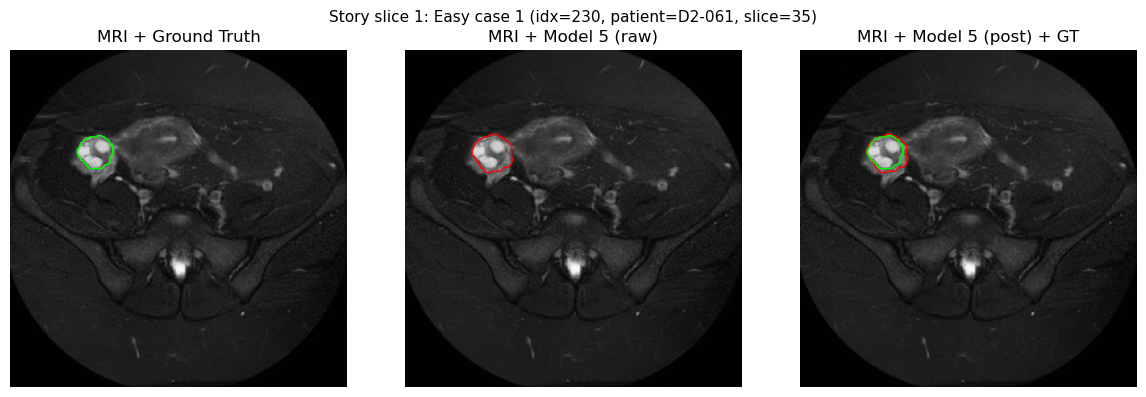

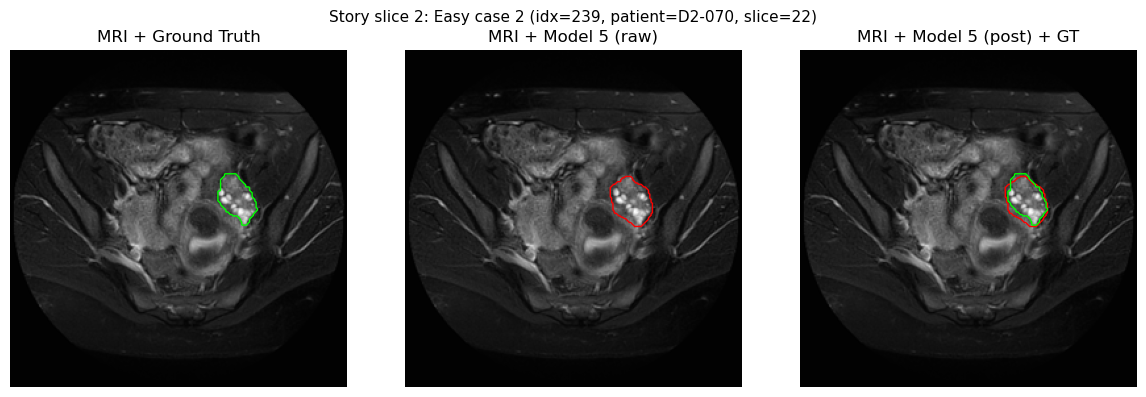

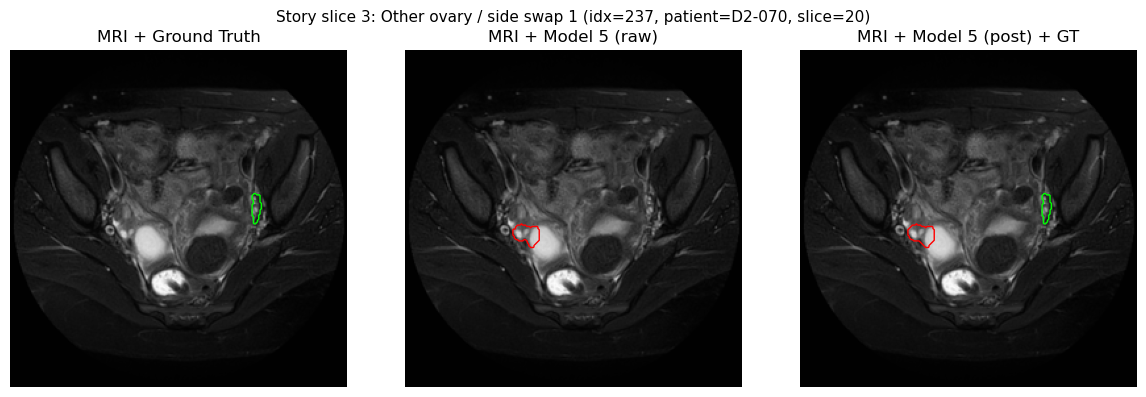

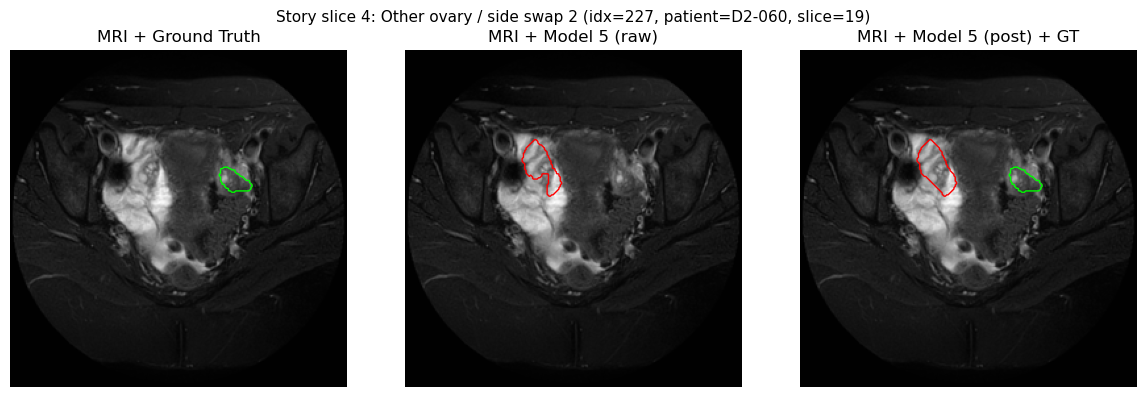

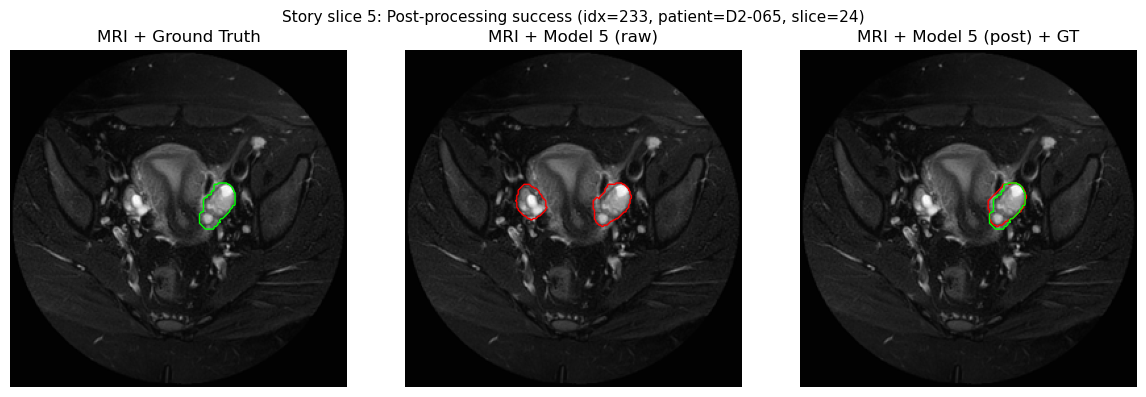

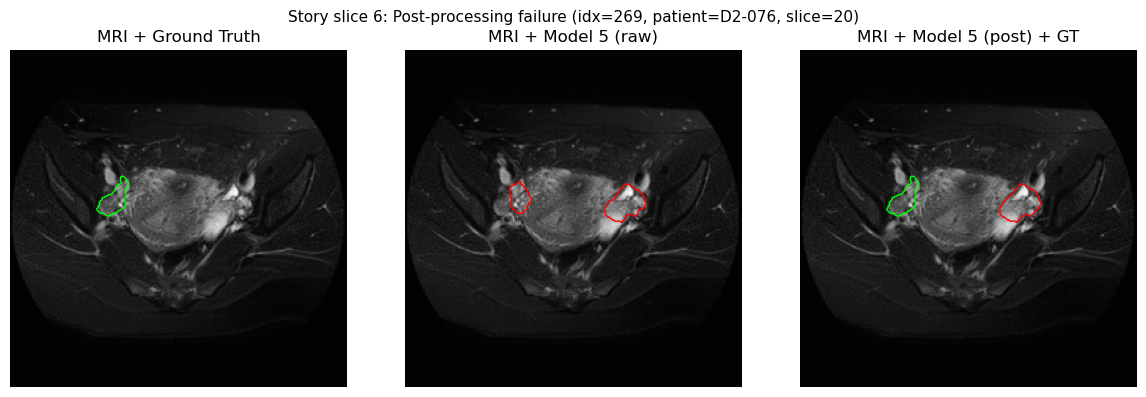

In [12]:
# === Overlay plots for story slices (Model 5 raw vs post-processed) ===

from src.RAovSeg_tools import postprocess_

# Indices you selected
easy_1_idx         = 230  # D2-061, slice 35
easy_2_idx         = 239  # D2-070, slice 22
other_ovary_1_idx  = 237  # D2-070, slice 20
other_ovary_2_idx  = 227  # D2-060, slice 19
post_success_idx   = 233  # D2-065, slice 24
post_failure_idx   = 269  # D2-076, slice 2

story_index_map = {
    "Easy case 1":                 easy_1_idx,
    "Easy case 2":                 easy_2_idx,
    "Other ovary / side swap 1":   other_ovary_1_idx,
    "Other ovary / side swap 2":   other_ovary_2_idx,
    "Post-processing success":     post_success_idx,
    "Post-processing failure":     post_failure_idx,
}

def plot_overlays_for_story_slices(index_map, model, title_prefix="Story slice"):
    """
    For each entry in index_map {label: dataset_idx}:
      Col 1: MRI + GT (green)
      Col 2: MRI + Model 5 raw prediction (red)
      Col 3: MRI + Model 5 post-processed (red) + GT (green)
    """
    for i, (label, idx) in enumerate(index_map.items()):
        # Fetch image + mask
        img_plain, mask_tensor = val_full_plain[idx]
        img_prep, _ = val_full_prep[idx]  # what model 5 actually sees

        mri_np = img_plain.squeeze().numpy()
        gt_np = mask_tensor.squeeze().numpy().astype(np.uint8)

        # Model 5 predictions (preprocessed input)
        model.eval()
        with torch.no_grad():
            img_batch = img_prep.unsqueeze(0).to(device)
            logits = model(img_batch)
            probs = torch.sigmoid(logits)
            pred_raw_np = (probs > 0.5).float().squeeze().cpu().numpy().astype(np.uint8)

        # Post-process prediction
        pred_post_np = postprocess_(pred_raw_np.astype(np.uint8))

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        slice_info = val_full_plain.slice_map[idx]
        patient_id = val_full_plain.manifest.iloc[slice_info['patient_index']]['patient_id']
        slice_index = slice_info['slice_index']

        fig.suptitle(
            f"{title_prefix} {i+1}: {label} "
            f"(idx={idx}, patient={patient_id}, slice={slice_index})",
            fontsize=11
        )

        # Panel 1: MRI + GT
        axes[0].imshow(mri_np, cmap="gray")
        axes[0].contour(gt_np, levels=[0.5], colors="lime", linewidths=1)
        axes[0].set_title("MRI + Ground Truth")
        axes[0].axis("off")

        # Panel 2: MRI + Model 5 raw
        axes[1].imshow(mri_np, cmap="gray")
        if pred_raw_np.max() > 0:
            axes[1].contour(pred_raw_np, levels=[0.5], colors="red", linewidths=1)
        axes[1].set_title("MRI + Model 5 (raw)")
        axes[1].axis("off")

        # Panel 3: MRI + Model 5 post + GT
        axes[2].imshow(mri_np, cmap="gray")
        if pred_post_np.max() > 0:
            axes[2].contour(pred_post_np, levels=[0.5], colors="red", linewidths=1)
        axes[2].contour(gt_np, levels=[0.5], colors="lime", linewidths=1)
        axes[2].set_title("MRI + Model 5 (post) + GT")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

# Run this to generate the overlay figures for the report
plot_overlays_for_story_slices(story_index_map, model5)


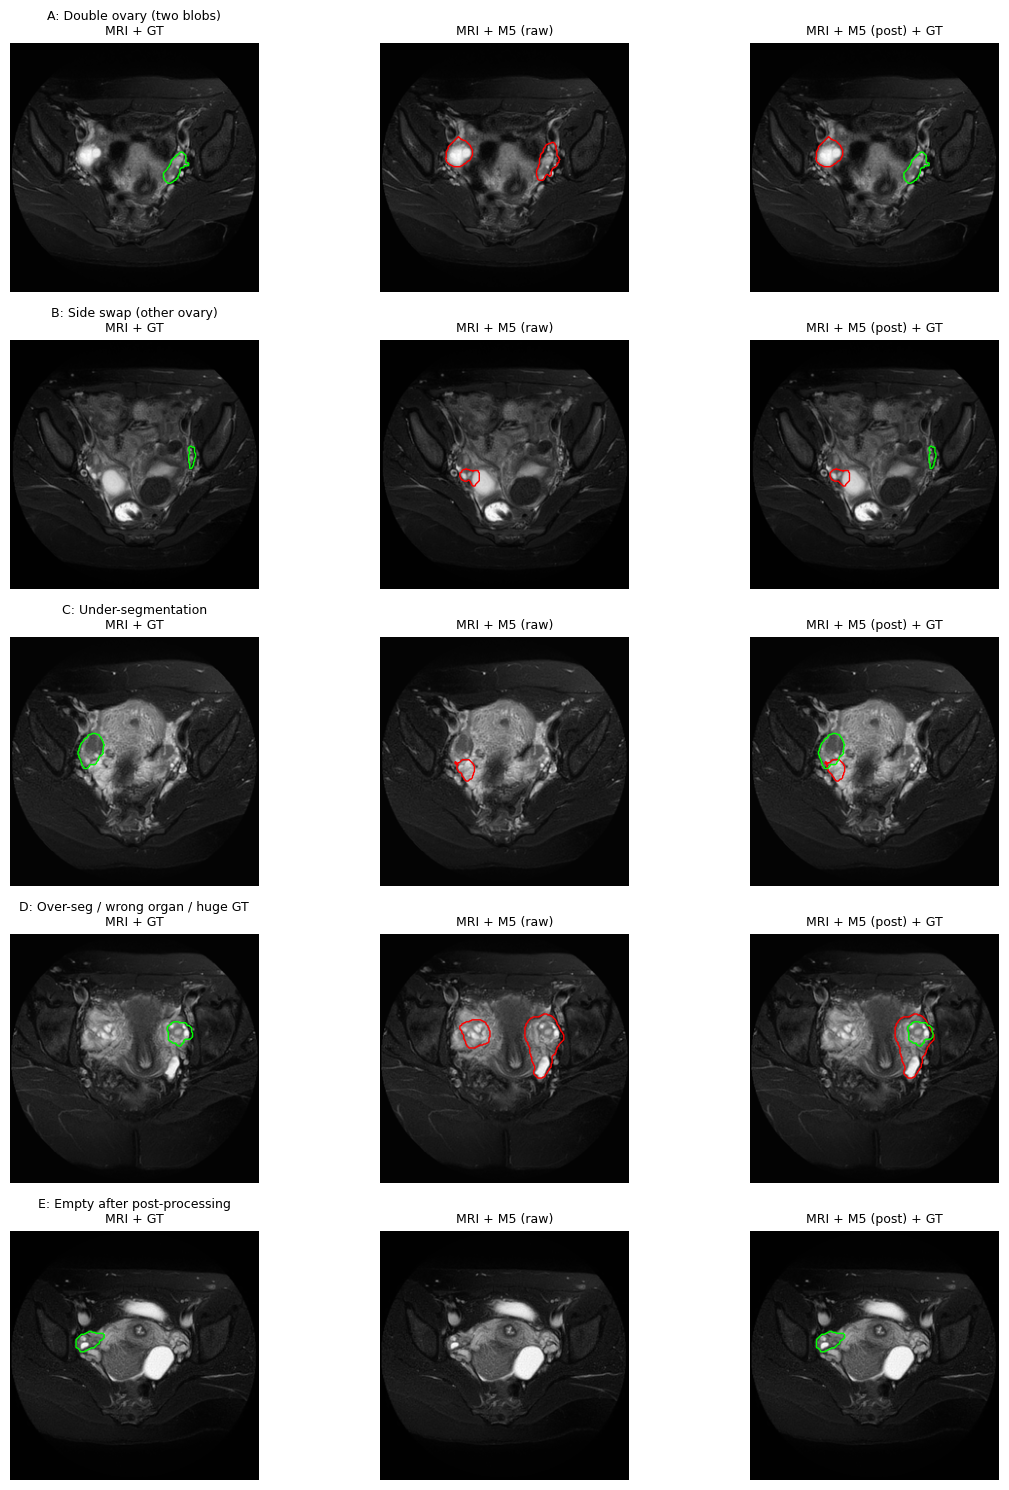

In [13]:
# === Failure taxonomy grid for Model 5 ===

# Indices for each failure type (from your selection)
typeA_double_idx = 215  # D2-058, slice 19
typeB_side_idx   = 237  # D2-070, slice 20  (same as other_ovary_1)
typeC_under_idx  = 220  # D2-059, slice 21
typeD_over_idx   = 225  # D2-060, slice 17
typeE_empty_idx  = 267  # D2-076, slice 18

failure_examples = {
    "A: Double ovary (two blobs)":         [typeA_double_idx],
    "B: Side swap (other ovary)":          [typeB_side_idx],
    "C: Under-segmentation":               [typeC_under_idx],
    "D: Over-seg / wrong organ / huge GT": [typeD_over_idx],
    "E: Empty after post-processing":      [typeE_empty_idx],
}

def plot_failure_taxonomy(failure_dict, model):
    """
    failure_dict: {label_str: [dataset_idx1, ...]}
    Each row in the grid is one example:
       Col 1: MRI + GT
       Col 2: MRI + Model 5 raw
       Col 3: MRI + Model 5 post + GT
    """
    rows = sum(len(v) for v in failure_dict.values())
    num_cols = 3

    fig, axes = plt.subplots(rows, num_cols, figsize=(4 * num_cols, 3 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    model.eval()
    row_idx = 0

    for label, idx_list in failure_dict.items():
        for idx in idx_list:
            img_plain, mask_tensor = val_full_plain[idx]
            img_prep, _ = val_full_prep[idx]

            mri_np = img_plain.squeeze().numpy()
            gt_np = mask_tensor.squeeze().numpy().astype(np.uint8)

            # Model 5 raw prediction
            with torch.no_grad():
                img_batch = img_prep.unsqueeze(0).to(device)
                logits = model(img_batch)
                probs = torch.sigmoid(logits)
                pred_raw_np = (probs > 0.5).float().squeeze().cpu().numpy().astype(np.uint8)

            # Post-processed prediction
            pred_post_np = postprocess_(pred_raw_np.astype(np.uint8))

            slice_info = val_full_plain.slice_map[idx]
            patient_id = val_full_plain.manifest.iloc[slice_info['patient_index']]['patient_id']
            slice_index = slice_info['slice_index']

            ax_row = axes[row_idx]

            # Col 0: MRI + GT
            ax_row[0].imshow(mri_np, cmap="gray")
            ax_row[0].contour(gt_np, levels=[0.5], colors="lime", linewidths=1)
            ax_row[0].set_title(f"{label}\nMRI + GT", fontsize=9)
            ax_row[0].axis("off")

            # Col 1: MRI + Model 5 raw
            ax_row[1].imshow(mri_np, cmap="gray")
            if pred_raw_np.max() > 0:
                ax_row[1].contour(pred_raw_np, levels=[0.5], colors="red", linewidths=1)
            ax_row[1].set_title("MRI + M5 (raw)", fontsize=9)
            ax_row[1].axis("off")

            # Col 2: MRI + Model 5 post + GT
            ax_row[2].imshow(mri_np, cmap="gray")
            if pred_post_np.max() > 0:
                ax_row[2].contour(pred_post_np, levels=[0.5], colors="red", linewidths=1)
            ax_row[2].contour(gt_np, levels=[0.5], colors="lime", linewidths=1)
            ax_row[2].set_title("MRI + M5 (post) + GT", fontsize=9)
            ax_row[2].axis("off")

            # Y-label with index/patient/slice info
            ax_row[0].set_ylabel(
                f"idx={idx}\npat={patient_id}\nslice={slice_index}",
                rotation=0, fontsize=7, labelpad=32, va="center"
            )

            row_idx += 1

    plt.tight_layout()
    plt.show()

# Run this to generate the taxonomy figure
plot_failure_taxonomy(failure_examples, model5)
